In [17]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving pac

In [18]:
Pkg.status()

Status `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
  [717857b8] DSP v0.8.4
  [a93c6f00] DataFrames v1.8.1
⌃ [31c24e10] Distributions v0.25.122
⌃ [38e38edf] GLM v1.9.0
  [511e77fe] IonSim v0.5.2
  [2fda8390] LsqFit v0.15.1
⌃ [91a5bcdd] Plots v1.41.3
  [92933f4c] ProgressMeter v1.11.0
  [d330b81b] PyPlot v2.11.6
  [6e0679c1] QuantumOptics v1.2.4
⌃ [295af30f] Revise v3.12.3
  [a1b2c3d4] SQRLab v0.1.0 `C:\Users\jewoo\projects\SQRLab`
  [10745b16] Statistics v1.11.1
⌃ [2913bbd2] StatsBase v0.34.9
⌃ [789caeaf] StochasticDiffEq v6.87.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [19]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [20]:
function pulse(T:: Chamber , tspan, pitime)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime*1e6/2

    res_intensity = intensity_from_pitime(L, pitime, T.iontrap.ions[1], ("g", "e"), T)

    function intensity_funtion(t)
    if(t<=pi2_time)
        return res_intensity
    elseif(t>=tspan[end] - pi2_time)
        return res_intensity
    else
        return 0.0
    end

    end
    intensity!(L, intensity_funtion)

    function phase_funtion(t)
        if(t<=pi2_time)
            return 2*pi
        elseif(t>=tspan[end] - pi2_time)
            return pi
        else
            return 0.0
        end
    end

    phase!(L, phase_funtion)
    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time)
    pitime = 4e-6
    tspan = 0: 0.1: wait_time+4

    h = pulse(T, tspan, pitime)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 7.291469960190796e-7 m
Δ: 10000 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 4.7164384027429946e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π


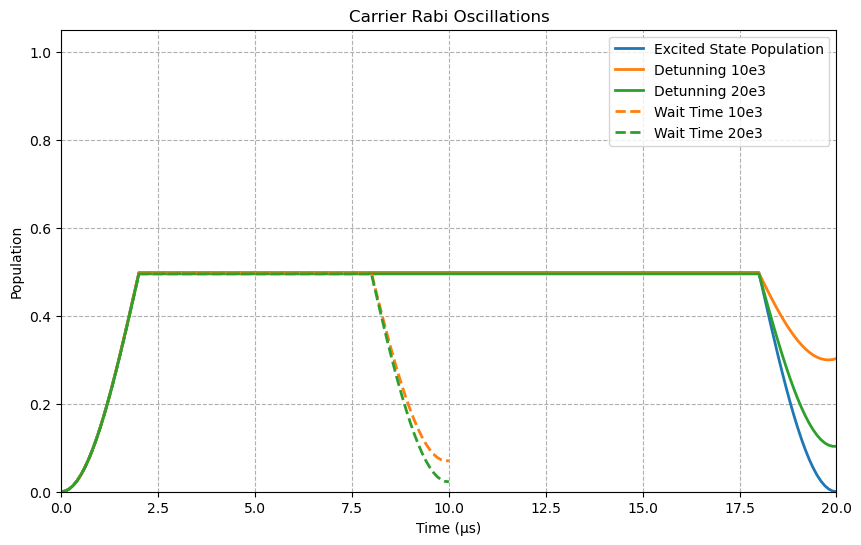

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [22]:
tspan = 0:0.1:20
# Solve the time evolution using the Schrödinger equation solver from QuantumOptics.jl
#h = pulse(T, tspan, 4e-6)
h = experiment(T, 16)
tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)


# 5. Analyze and Visualize the Results
# Calculate the population in the excited state |e⟩ over time
excited_pop = expect(ionprojector(T, "e"), sol)
print(L)



L1 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T1 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L1]
)
polarization!(L1, (x̂ - ẑ)/√2)
wavevector!(L1, (x̂ + ẑ)/√2);
wavelength_from_transition!(L1, C, ("g", "e"), T1)
detuning!(L1, 10000)
#h1 = pulse(T1, tspan, 4e-6)
h1 = experiment(T1, 16)
tspan1 = 0:0.1:10
#h1_wait = pulse(T1, tspan1, 4e-6)
h1_wait = experiment(T1, 6)
tout1, sol1 = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
excited_pop1 = expect(ionprojector(T1, "e"), sol1)

tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
excited_pop1_wait = expect(ionprojector(T1, "e"), sol1_wait)
print(L1)


L2 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T2 = Chamber(
    iontrap=chain,
    B=4e4,              # Magnetic field in Tesla
    δB = 1e-6,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L2]
)
polarization!(L2, (x̂ - ẑ)/√2)
wavevector!(L2, (x̂ + ẑ)/√2);
wavelength_from_transition!(L2, C, ("g", "e"), T2)
#detuning!(L2, 20000)

#h2 = pulse(T2, tspan, 4e-6)
h2 = experiment(T2, 16)
h2_wait = experiment(T2, 6)
tout2, sol2 = timeevolution.schroedinger_dynamic(tspan, ψ₀, h2)

excited_pop2 = expect(ionprojector(T2, "e"), sol2)

tout2_wait, sol2_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h2_wait)
excited_pop2_wait = expect(ionprojector(T2, "e"), sol2_wait)

print(L2)



# Create the plot using PyPlot
figure(figsize=(10, 6))
plot(tout, real.(excited_pop), label="Excited State Population", color="C0", linewidth=2)
plot(tout1, real.(excited_pop1), label="Detunning 10e3", color="C1", linewidth=2)
plot(tout2, real.(excited_pop2), label="Detunning 20e3", color="C2", linewidth=2)


plot(tout1_wait, real.(excited_pop1_wait), label="Wait Time 10e3", color="C1", linestyle="--", linewidth=2)
plot(tout2_wait, real.(excited_pop2_wait), label="Wait Time 20e3", color="C2", linestyle="--", linewidth=2)


xlim(0, 20)
xlabel("Time (μs)")
ylabel("Population")
title("Carrier Rabi Oscillations")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())


In [23]:
function plot_Bfluc(n, deltaB)
    L3 = Laser()

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    T3 = Chamber(
        iontrap=chain,
        B=4e-4,              # Magnetic field in Tesla
        δB = deltaB,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L3]
    )
    polarization!(L3, (x̂ - ẑ)/√2)
    wavevector!(L3, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L3, C, ("g", "e"), T3)
    
    h3 = pulse(T3, tspan, 4e-6)

    h3_wait = pulse(T3, tspan1, 4e-6)
    tout3, sol3 = timeevolution.schroedinger_dynamic(tspan, ψ₀, h3)

    excited_pop3 = expect(ionprojector(T3, "e"), sol3)

    tout3_wait, sol3_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h3_wait)
    excited_pop3_wait = expect(ionprojector(T3, "e"), sol3_wait)

    print(L3)
    
    plot(tout3, real.(excited_pop3), label="B_flux $deltaB",  color="C$n", linewidth=2)
    plot(tout3_wait, real.(excited_pop3_wait), color="C$n", linestyle="--", linewidth=2)


end

plot_Bfluc (generic function with 1 method)

λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 7.291469960190796e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 1.0 ⋅ 2π
λ: 7.2914699601

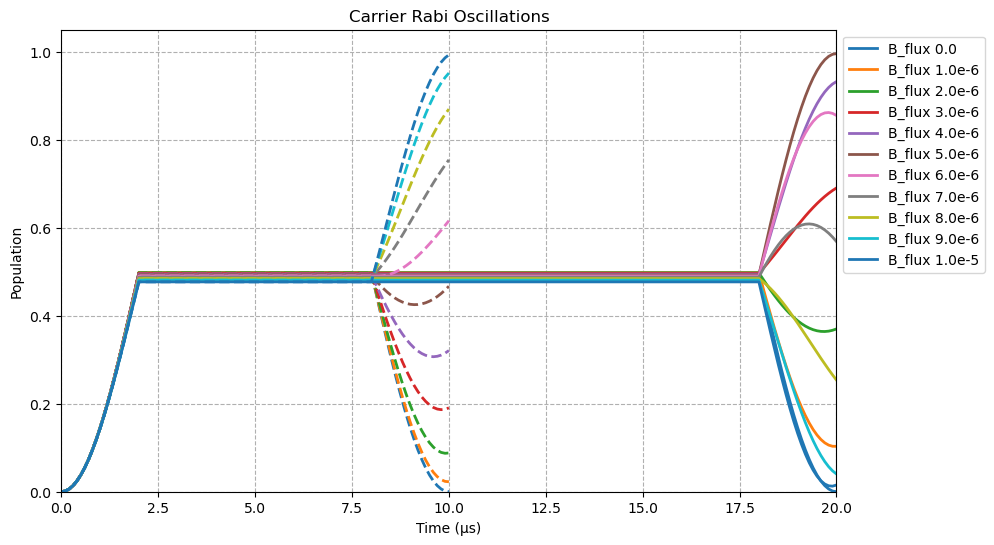

In [24]:
B_span = 0:1e-6:1e-5
figure(figsize=(10, 6))
ct = 0
for w in B_span
    plot_Bfluc(ct, w)
    ct = ct+1
end
xlim(0, 20)
    xlabel("Time (μs)")
    ylabel("Population")
    title("Carrier Rabi Oscillations")
    ylim(0, 1.05)
    grid(true, linestyle="--")
    legend(loc="upper left", bbox_to_anchor=(1, 1))
    show()
    display(gcf())

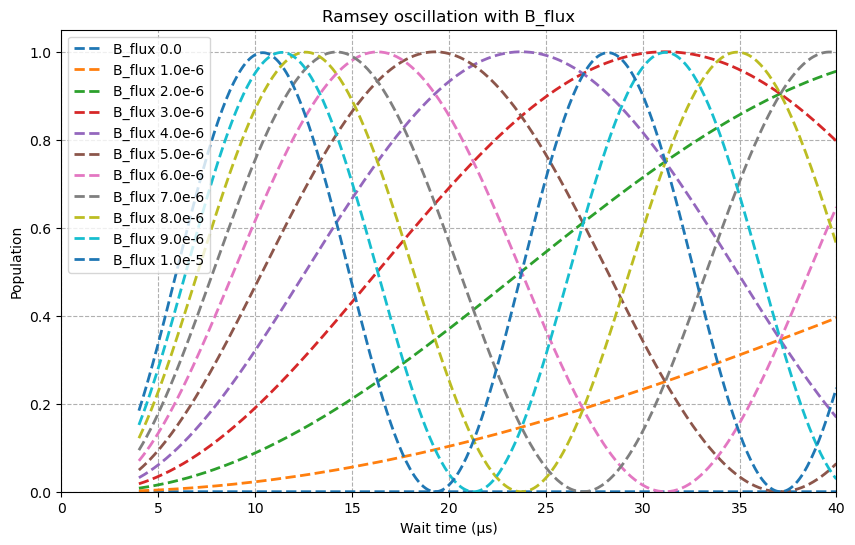

In [25]:
waittime = 4:0.1:40
B_span = 0:1e-6:1e-5



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
for delB in B_span

   
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
xlim(0, 40)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


In [10]:
waittime = 4:0.1:40
B_span = 0:1e-6:1e-5



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
for delB in B_span

   
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, -delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
xlim(0, 40)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


UndefVarError: UndefVarError: `Laser` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [11]:
using StochasticDiffEq
using QuantumOptics: timeevolution, stochastic, Basis

In [12]:
ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

UndefVarError: UndefVarError: `ions` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
mode.N = 10
polarization!(L, (x̂ - ẑ)/√2)
hs = hamiltonian(T)
hsvec = (t, ψ) -> [hs(t, ψ)]
tspan = collect(0:10.:30000)

Ntraj = 100
ex = zero(tspan)
β = 1e-2
σ = √(2β)
w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
w.dt = 0.1;
w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
tout, sol = stochastic.schroedinger_dynamic(tspan, ψ₀, h, hsvec, noise=w,
    normalize_state=false, dt=0.1)

    # post-process results
    ex .+= real.(expect(dm(ψ0_ion_1) ⊗ one(mode), sol)) ./ Ntraj
end

figure(figsize=(10, 6))
plot(tspan, ex, color="C0", label="Simulated Contrast")
xlim(tspan[1], tspan[end])
ylim(0, 1)
xlabel("Time (μs)")
ylabel("Ramsey Signal")
display(gcf())

UndefVarError: UndefVarError: `mode` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in StatsBase.
    - Also exported by Distributions (loaded but not imported in Main).
Hint: a global variable of this name also exists in ADTypes.

In [15]:
waittime = 4:0.1:40
B_span = 0:1e-12:3e-12



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=0.37e-3,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
for delB in B_span

   
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
xlim(0, 40)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


UndefVarError: UndefVarError: `Laser` not defined in `Main`
Suggestion: check for spelling errors or missing imports.